In [75]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pathlib import Path
import json
from matplotlib.patches import ConnectionPatch
from sklearn.cluster import KMeans, DBSCAN, MeanShift, HDBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from collections import defaultdict
from tqdm import tqdm
from scipy.linalg import inv

PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'casp_da'

In [77]:
proteins = [
  'T1024', 'T1030', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1',
  'T1025-D1', 'T1028-D1', 'T1030-D1', 'T1053-D2', 'T1057-D1','T1058-D1', 'T1058-D2'
]
da = DihedralAdherence(proteins[5], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[1,1,1,1], 
                      mode='full_window', weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cpu')
                    #   mode='ml', weights_file='ml_runs/best_model-kde_16-32_383.pt', device='cpu')

da.load_results_da()
center_idx_ctxt = da.queries[-1].get_center_idx()
winsize_ctxt = da.queries[-1].winsize
if center_idx_ctxt < 0:
    center_idx_ctxt = winsize_ctxt + center_idx_ctxt
da.seqs_for_window = da.seqs[center_idx_ctxt:-(winsize_ctxt - center_idx_ctxt - 1)]

Initializing T1053-D1 ...
Results already exist
Casp ID: T1053-D1 	PDB: 7m7a
Structure exists: 'pdb/pdb7m7a.ent' 
UniProt ID: Q5ZRA8


In [78]:
def diff(x1, x2):
    d = np.abs(x1 - x2)
    return np.minimum(d, 360-d)

def get_phi_psi_dist(q, seq_ctxt):
    seq = q.get_subseq(seq_ctxt)
    phi_psi_dist = q.results_window[q.results_window.seq == seq]
    phi_psi_dist = phi_psi_dist[['match_id', 'window_pos', 'phi', 'psi']].pivot(index='match_id', columns='window_pos', values=['phi', 'psi'])
    phi_psi_dist.columns = [f'{c[0]}_{c[1]}' for c in phi_psi_dist.columns.to_flat_index()]
    phi_psi_dist = phi_psi_dist.dropna(axis=0)
    return phi_psi_dist

def get_xrays(ins, q, seq_ctxt, return_df=False):
    center_idx = q.get_center_idx_pos()
    xray_pos = ins.xray_phi_psi[ins.xray_phi_psi.seq_ctxt == seq_ctxt].pos.iloc[0]
    xrays = ins.xray_phi_psi[(ins.xray_phi_psi.pos >= xray_pos-center_idx) & (ins.xray_phi_psi.pos < xray_pos-center_idx+q.winsize)].copy()
    xray_point = np.concatenate([xrays['phi'].values, xrays['psi'].values])
    if return_df:
        return xray_point, xrays
    return xray_point

def get_afs(ins, q, seq_ctxt, return_df=False):
    center_idx = q.get_center_idx_pos()
    af_pos = ins.af_phi_psi[ins.af_phi_psi.seq_ctxt == seq_ctxt].pos.iloc[0]
    afs = ins.af_phi_psi[(ins.af_phi_psi.pos >= af_pos-center_idx) & (ins.af_phi_psi.pos < af_pos-center_idx+q.winsize)].copy()
    af_point = np.concatenate([afs['phi'].values, afs['psi'].values])
    if return_df:
        return af_point, afs
    return af_point

def get_preds(ins, q, seq_ctxt):
    center_idx = q.get_center_idx_pos()
    pred_pos = ins.phi_psi_predictions[ins.phi_psi_predictions.seq_ctxt == seq_ctxt].pos.unique()
    if len(pred_pos) == 0:
        print(f"No predictions for {seq_ctxt}")
    if len(pred_pos) > 1:
        print(f"Multiple predictions for {seq_ctxt}")
        raise ValueError
    pred_pos = pred_pos[0]
    preds = ins.phi_psi_predictions[(ins.phi_psi_predictions.pos >= pred_pos-center_idx) & (ins.phi_psi_predictions.pos < pred_pos-center_idx+q.winsize)].copy()
    preds = preds[['protein_id', 'pos', 'phi', 'psi']].pivot(index='protein_id', columns='pos', values=['phi', 'psi'])
    preds.columns = [f'{c[0]}_{c[1]-pred_pos+center_idx}' for c in preds.columns.to_flat_index()]
    preds = preds.dropna(axis=0)
    return preds

def calc_xray_score(phi_psi_dist, xrays, q, precomputed_dists):
    # Distance to nearest cluster average
    d = np.linalg.norm(diff(xrays[np.newaxis,:], phi_psi_dist.iloc[:,:q.winsize*2].values), axis=1)
    d = pd.DataFrame({'d': d, 'c': phi_psi_dist.cluster})
    nearest_cluster = d.groupby('c').d.mean().idxmin()
    cluster_points = phi_psi_dist[phi_psi_dist.cluster == nearest_cluster].iloc[:,:q.winsize*2].values
    # cluster_avg = cluster_points.mean(axis=0)
    cluster_medoid = get_cluster_medoid(phi_psi_dist, precomputed_dists, nearest_cluster, q)
    
    xray_dist = np.sqrt((diff(xrays, cluster_medoid)**2).sum())

    return xray_dist, nearest_cluster

def estimate_icov(q, phi_psi_dist_c, cluster_medoid):
    # estimate covariance matrix
    cluster_points = phi_psi_dist_c.iloc[:,:q.winsize*2].values
    diffs = diff(cluster_points, cluster_medoid)

    # cov = []
    # for diffi in diffs:
    #     diffi = diffi.reshape(-1, 1)
    #     cov.append(diffi @ diffi.T)
    # cov = np.array(cov).sum(axis=0) / (diffs.shape[0] - 1)
    cov = (diffs[...,np.newaxis] @ diffs[:,np.newaxis]).sum(axis=0) / (diffs.shape[0] - 1)
    cov = cov + np.eye(cov.shape[0]) * 1e-6 # add small value to diagonal to avoid singular matrix
    if np.any(cov <= 0):
        print("Non-positive covariance matrix")
        return None
    if np.any(cov.diagonal() < 1):
        print("Covariance matrix less than 1")
        return None
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    if np.any(eigenvalues < 0):
        print("Negative eigenvalues - non-positive semi-definite covariance matrix")
        return None
    icov = inv(cov)
    return icov

def get_target_cluster(q, phi_psi_dist, point):
    d = np.linalg.norm(diff(point[np.newaxis,:], phi_psi_dist.iloc[:,:q.winsize*2].values), axis=1)
    d = pd.DataFrame({'d': d, 'c': phi_psi_dist.cluster})
    nearest_cluster = d.groupby('c').d.mean().idxmin()
    return nearest_cluster

def calc_maha_xray(phi_psi_dist, xrays, q, precomputed_dists, af):
    target_cluster = get_target_cluster(q, phi_psi_dist, af)
    cluster_medoid = get_cluster_medoid(phi_psi_dist, precomputed_dists, target_cluster, q)
    icov = estimate_icov(q, phi_psi_dist[phi_psi_dist.cluster == target_cluster], cluster_medoid)
    if icov is None:
        return None, target_cluster    

    # xray_maha_
    xray_diff = diff(xrays, cluster_medoid)
    xray_maha = np.sqrt(xray_diff @ icov @ xray_diff)

    return xray_maha, target_cluster

def calc_maha_preds(phi_psi_dist, preds, q, precomputed_dists, af):
    target_cluster = get_target_cluster(q, phi_psi_dist, af)
    cluster_medoid = get_cluster_medoid(phi_psi_dist, precomputed_dists, target_cluster, q)
    icov = estimate_icov(q, phi_psi_dist[phi_psi_dist.cluster == target_cluster], cluster_medoid)
    if icov is None:
        return None

    # Distance from preds to target
    preds_diff = diff(preds.iloc[:,:q.winsize*2].values, cluster_medoid)
    preds_maha = np.sqrt((preds_diff @ icov @ preds_diff.T).diagonal())
    return preds_maha

def calc_score(q, preds, phi_psi_dist, intracluster_dists, xrays=None, afs=None):
    # Distance to nearest cluster average
    d = np.linalg.norm(diff(preds.iloc[:,:q.winsize*2].values[:,np.newaxis], phi_psi_dist.iloc[:,:q.winsize*2].values), axis=2)
    average_dists = []
    clusters = phi_psi_dist.cluster.unique()
    for c in clusters:
        average_dists.append(d[:,phi_psi_dist.cluster == c].mean(axis=1))
    average_dists = np.array(average_dists).T
    min_dists = average_dists.min(axis=1)
    nearest_clusters = average_dists.argmin(axis=1)

    preds_dist = pd.DataFrame(index=preds.index, columns=['dist'])
    preds_dist['dist'] = preds_dist['dist'].astype(float)
    for c in clusters:
        cluster_points = phi_psi_dist[phi_psi_dist.cluster == c].iloc[:,:q.winsize*2].values
        cluster_avg = cluster_points.mean(axis=0) # TODO: use medoid
        preds_c = preds[nearest_clusters == c].iloc[:,:q.winsize*2].values
        preds_dists_c = np.linalg.norm(diff(preds_c, cluster_avg), axis=1)
        preds_dist.loc[nearest_clusters == c, 'dist'] = preds_dists_c

    return preds_dist.dist.values

# def calc_intra_cluster(phi_psi_dist, precomputed_dists):
#     ds = {}
#     for c in phi_psi_dist.cluster.unique():
#         d = precomputed_dists[phi_psi_dist.cluster == c][:,phi_psi_dist.cluster == c]
#         ds[c] = d.sum() / (d.shape[0] * (d.shape[0]-1))
#     return ds

def get_cluster_medoid(phi_psi_dist, precomputed_dists, c, q):
    d = precomputed_dists[phi_psi_dist.cluster == c][:,phi_psi_dist.cluster == c]
    return phi_psi_dist[phi_psi_dist.cluster == c].iloc[d.sum(axis=1).argmin(), :q.winsize*2].values

def precompute_dists(phi_psi_dist):
    def diff(x1, x2):
            d = np.abs(x1 - x2)
            return np.minimum(d, 360-d)
    precomputed_dists = np.linalg.norm(diff(phi_psi_dist.values[:,np.newaxis], phi_psi_dist.values), axis=2)
    return precomputed_dists
    
# def assign_clusters(phi_psi_dist, precomputed_dists, eps=75):
#     phi_psi_dist['cluster'] = DBSCAN(eps=eps, min_samples=5, metric='precomputed').fit(precomputed_dists).labels_
#     n_clusters = len(phi_psi_dist.cluster.unique())
#     return n_clusters

def assign_clusters(phi_psi_dist, precomputed_dists, min_cluster_size=20):
    precomputed_dists = precomputed_dists.copy()
    # phi_psi_dist['cluster'] = HDBSCAN(min_cluster_size=20, min_samples=5, metric='precomputed').fit(precomputed_dists).labels_
    phi_psi_dist['cluster'] = HDBSCAN(
        min_cluster_size=min_cluster_size, 
        # min_samples=5, 
        metric='precomputed', 
        allow_single_cluster=True,
        cluster_selection_epsilon=30
    ).fit(precomputed_dists).labels_
    n_clusters = len(phi_psi_dist.cluster.unique())
    return n_clusters - 1

def plot(q, phi_psi_dist, xrays=None, c=None):
    fig, axes = plt.subplots(1,q.winsize, figsize=(q.winsize*4,5))
    if xrays is not None:
        xrays = xrays.reshape(2, -1)
    phi_psi_dist_points = phi_psi_dist.iloc[:,:q.winsize*2].values.reshape(phi_psi_dist.shape[0], 2, -1)
    for i in range(q.winsize):
        axes[i].scatter(phi_psi_dist_points[:,0,i], phi_psi_dist_points[:,1,i], marker='.')
        if c is not None:
            axes[i].scatter(phi_psi_dist_points[phi_psi_dist.cluster==c,0,i], phi_psi_dist_points[phi_psi_dist.cluster==c,1,i], c='orange', zorder=5)
        if xrays is not None:
            axes[i].scatter(xrays[0,i], xrays[1,i], c='r', marker='X', zorder=10, s=100)
        axes[i].set_xlim(-180,180)
        axes[i].set_ylim(-180,180)

In [79]:
class Thread():
    _id = 0
    def __init__(self):
        # self.medoid = initial_medoid # last medoid of thread
        self.length = 1 # different from len(self.members)
        self.id = Thread._id
        self.alive = True
        Thread._id += 1
        self.members = []
    
    def __len__(self):
        return self.length
    
    def __repr__(self):
        return f"Thread[{self.id}]={self.length}"

    def __eq__(self, other):
        if isinstance(other, Thread):
            return self.id == other.id
        return False

In [80]:
class Medoid():
    def __init__(self, index, medoids):
        self.index = index # index of this medoid in the window
        self.thread = None # pointer to medoid thread this belonds to
        self.medoids = medoids # pointer to all medoids of this window
    
    @property
    def medoid(self):
        return self.medoids[self.index]
    
    def assign_thread(self, thread):
        self.thread = thread
        self.thread.members.append(self)
    
    def __repr__(self):
        return f"Medoid[{self.thread}]({self.medoids[self.index]})"

In [81]:
class PDBMineWindow():
    def __init__(self, q, seq_ctxt, index):
        self.seq_ctxt = seq_ctxt
        self.index = index
        self.medoids = None
        self.q = q
        self.min_cluster_size = 20
        self.find_medoids()
    
    def find_medoids(self):
        phi_psi_dist = get_phi_psi_dist(self.q, self.seq_ctxt)
        precomputed_dists = precompute_dists(phi_psi_dist)
        n_clusters = assign_clusters(phi_psi_dist, precomputed_dists, min_cluster_size=self.min_cluster_size)
        while n_clusters == 0:
            self.min_cluster_size = self.min_cluster_size // 2
            n_clusters = assign_clusters(phi_psi_dist, precomputed_dists, self.min_cluster_size)
        self._medoids = np.array([get_cluster_medoid(
            phi_psi_dist, precomputed_dists, c, self.q
        ) for c in range(n_clusters) if c != -1])
        self.medoids = [Medoid(i, self._medoids) for i in range(len(self._medoids))]
    
    def extend_and_spawn_threads(self, other, threshold=30):
        # Distnace from each medoid of this window to each medoid of other window
        range1 = np.concatenate([np.arange(self.q.winsize-1), np.arange(self.q.winsize, self.q.winsize*2-1)])
        range2 = np.concatenate([np.arange(1, self.q.winsize), np.arange(self.q.winsize+1, self.q.winsize*2)])
        dists = np.linalg.norm(diff(self._medoids[:,np.newaxis,range1], other._medoids[:,range2]), axis=2)

        # Extend clusters with close matches
        closest = dists.argmin(axis=1)
        min_dists = dists.min(axis=1)
        for i,medoid in enumerate(self.medoids):
            if min_dists[i] < threshold:
                # extend thread
                if other.medoids[closest[i]].thread is None:
                    medoid.thread.length += 1
                    other.medoids[closest[i]].assign_thread(medoid.thread)
                # other medoid already assigned to a thread, merge them
                else:
                    thread = other.medoids[closest[i]].thread
                    # backtrack and reassign all medoids in this thread to the new thread
                    for member in medoid.thread.members:
                        member.assign_thread(thread)
                    
        # Spawn new threads from any medoids in other window that were not matched
        for i,medoid in enumerate(other.medoids):
            if medoid.thread is None:
                # spawn new thread
                medoid.thread = Thread()
    
    def __repr__(self):
        return f"PDBMineWindow({self.seq_ctxt}, {self.index})={len(self.medoids)}"

In [99]:
windows = []
for i,seq_ctxt in tqdm(enumerate(da.seqs_for_window)):
    window = PDBMineWindow(da.queries[0], seq_ctxt, i)
    
    # intialize medoid threads
    if i == 0:
        for medoid in window.medoids:
            medoid.assign_thread(Thread())
    # Extend existing threads or create new ones
    else:
        windows[-1].extend_and_spawn_threads(window, threshold=15)

    windows.append(window)
    # plot(da.queries[0], phi_psi_dist, c=phi_psi_dist.groupby('cluster').size().idxmax())

338it [04:14,  1.33it/s]


In [85]:
q = da.queries[0]
errors = []
for window in windows:
    longest_medoid = window.medoids[np.array([m.thread.length for m in window.medoids]).argmax()]
    xrays = get_xrays(da, da.queries[0], window.seq_ctxt)
    if xrays.shape[0] != q.winsize*2:
        print(f'missing xray data - {window.seq_ctxt}')
        continue
    # xray_medoid = window.medoids[np.linalg.norm(diff(xrays[np.newaxis, :], window._medoids), axis=1).argmin()]
    # error = np.linalg.norm(diff(longest_medoid.medoid, xray_medoid.medoid))
    error = np.linalg.norm(diff(longest_medoid.medoid, xrays))
    errors.append(error)
    print(window.seq_ctxt, error)

    # fig, axes = plt.subplots(1,4, figsize=(10,3))
    # def plot(medoid, axes):
    #     for i in range(q.winsize):
    #         axes[i].scatter(medoid[i], medoid[i+q.winsize], marker='.')
    #         axes[i].set_xlim(-180,180)
    #         axes[i].set_ylim(-180,180)
    # plot(longest_medoid.medoid, axes)
    # plot(xray_medoid.medoid, axes)
    # plot(xrays, axes)
errors = np.array(errors)
print(errors.mean(), errors.std())

KKALKES 170.25883915945167
KALKESQ 364.19849031270024
ALKESQL 246.73798232079002
LKESQLQ 188.7247471255109
KESQLQF 239.47290508634507
ESQLQFL 287.7797148574605
missing xray data - SQLQFLT
missing xray data - QLQFLTA
missing xray data - HQTYKVS
QTYKVSF 355.21084997222744
TYKVSFI 351.32045332239346
YKVSFIE 237.04476074634624
KVSFIEN 299.3724454771704
VSFIENG 343.40622547664685
SFIENGV 333.6063667209334
FIENGVI 282.69378570970326
IENGVIK 297.00182981092604
ENGVIKN 294.02365942734747
NGVIKNA 350.83577551173704
GVIKNAF 343.1382086003672
VIKNAFY 203.15704988885273
IKNAFYK 277.03799482933226
KNAFYKK 288.3762909376382
NAFYKKL 55.65151868913492
AFYKKLD 341.5456754879212
FYKKLDP 244.01127594218025
YKKLDPK 228.0264784107122
KKLDPKN 327.2914985107683
KLDPKNH 104.41885333897154
LDPKNHY 277.96875066142144
DPKNHYP 265.49157594635926
PKNHYPE 279.08913770319094
KNHYPEL 277.72180902924737
NHYPELL 292.2770727516767
HYPELLA 234.5231523107225
YPELLAK 290.9372753936474
PELLAKI 31.736756355826632
ELLAKIS 26.

<Axes: ylabel='Density'>

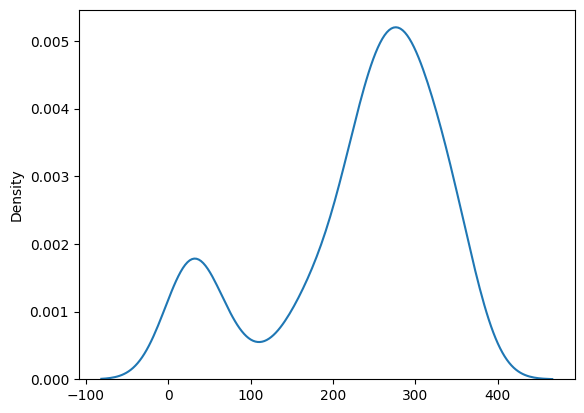

In [86]:
sns.kdeplot(errors)

In [95]:
errors

array([170.25883916, 364.19849031, 246.73798232, 188.72474713,
       239.47290509, 287.77971486, 355.21084997, 351.32045332,
       237.04476075, 299.37244548, 343.40622548, 333.60636672,
       282.69378571, 297.00182981, 294.02365943, 350.83577551,
       343.1382086 , 203.15704989, 277.03799483, 288.37629094,
        55.65151869, 341.54567549, 244.01127594, 228.02647841,
       327.29149851, 104.41885334, 277.96875066, 265.49157595,
       279.0891377 , 277.72180903, 292.27707275, 234.52315231,
       290.93727539,  31.73675636,  26.17270949, 355.00762991,
       263.72423253, 325.12548419, 288.43724321, 255.29674571,
       305.91236714,  27.12591283,  28.56754317, 371.21908333,
       223.06452701, 356.86671461, 322.11487259, 245.87053316,
       202.70208298, 177.20198551, 247.7356624 , 253.20539727,
       186.43521593, 216.56258796, 344.47006359, 342.28845327,
       345.8112857 , 174.28146072, 250.08240782, 353.89487022,
       221.6770246 , 229.45381118, 261.57172907, 313.01

Thread[665]=1
Medoid[Thread[665]=1]([-134.7  -71.5  -98.    69.4  126.7  142.1  -70.1   72.5])


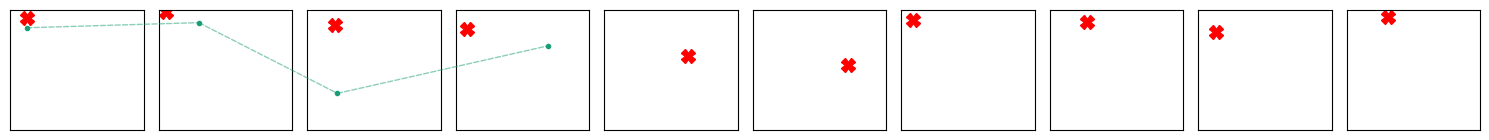

In [98]:
start_window = 11
window = windows[start_window]
q = da.queries[0]
thread = window.medoids[np.array([m.thread.length for m in window.medoids]).argmax()].thread
print(thread)
n_plots = 10
fig, axes = plt.subplots(1, n_plots, figsize=(15, 1.5), sharey=True)
colors = sns.color_palette('Dark2', len(axes)-q.winsize+1)
for i in range(len(axes)-q.winsize+1):
    for medoid in windows[i+start_window].medoids:
        if medoid.thread == thread:
            print(medoid)
            for k,j in enumerate(range(i, i+q.winsize)):
                axes[j].plot(medoid.medoid[k], medoid.medoid[k+q.winsize], marker='.', color=colors[i])
                if k != 0:
                    con = ConnectionPatch(
                        xyA=(medoid.medoid[k-1], medoid.medoid[k-1+q.winsize]), 
                        xyB=(medoid.medoid[k], medoid.medoid[k+q.winsize]), 
                        coordsA="data", coordsB="data", 
                        axesA=axes[j-1], axesB=axes[j], 
                        color=colors[i], lw=1, linestyle='--', alpha=0.5
                    )
                    fig.add_artist(con)
            break
for i,ax in enumerate(axes):
    xrays = get_xrays(da, q, windows[i+start_window].seq_ctxt)
    ax.plot(xrays[q.get_center_idx_pos()], xrays[q.winsize+q.get_center_idx_pos()], marker='X', color='r', markersize=10)
    # ax.plot(xrays[0], xrays[q.winsize], marker='X', color='r', markersize=10)
    ax.set_xlim(-180,180)
    ax.set_ylim(-180,180)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

In [121]:
n_cluster_plot = 10
q = da.queries[0]
# seq_ctxt = da.seqs_for_window[0]
seq_ctxt = da.seqs[da.seqs.tolist().index('AGILAGF')]
phi_psi_dist = get_phi_psi_dist(q, seq_ctxt)
n_points = phi_psi_dist.shape[0]
xray_point, xrays = get_xrays(da, q, seq_ctxt, return_df=True)
preds = get_preds(da, q, seq_ctxt)
# pred_id = 'T1024TS063_5'
pred_id = da.protein_ids[0]
pred = preds.loc[pred_id].values.reshape(2,-1)

precomputed_dists = precompute_dists(phi_psi_dist.iloc[:,:q.winsize*2])
n_clusters = assign_clusters(phi_psi_dist, precomputed_dists)
intracluster_dists = calc_intra_cluster(phi_psi_dist, precomputed_dists)
print(n_clusters, phi_psi_dist.cluster.value_counts())
sil_score = silhouette_score(phi_psi_dist[phi_psi_dist.cluster != -1].iloc[:,:-1], phi_psi_dist[phi_psi_dist.cluster != -1].cluster)
# print(sil_score)
# xray_sil, nearest_cluster = xray_sil_score(phi_psi_dist, xray_point, q)
n_unassigned = (phi_psi_dist.cluster == -1).sum()
precomputed_dists = precomputed_dists[phi_psi_dist['cluster'] != -1][:,phi_psi_dist['cluster'] != -1]
phi_psi_dist = phi_psi_dist[phi_psi_dist['cluster'] != -1]
xray_sil, nearest_cluster = calc_xray_score(phi_psi_dist, xray_point, q, intracluster_dists)
pred_sil, nearest_cluster_pred = calc_xray_score(phi_psi_dist, pred.flatten(), q, intracluster_dists)
print('Intracluster', nearest_cluster, intracluster_dists[nearest_cluster])
print('Xray:', xray_sil)
print('Pred:', pred_sil)

clusters = phi_psi_dist.groupby('cluster').count().sort_values('phi_0', ascending=False).index.values
clusters = np.concatenate([[nearest_cluster], clusters[clusters != nearest_cluster]])
# clusters = np.concatenate([[nearest_cluster_pred], clusters[clusters != nearest_cluster_pred]])
clusters_plot = clusters[:n_cluster_plot]
# cluster_aves = phi_psi_dist.groupby('cluster').mean().loc[clusters_plot]
medoids = []
for cluster in clusters:
    medoid = get_cluster_medoid(phi_psi_dist, precomputed_dists, cluster, q)
    medoids.append(medoid)
medoids = np.array(medoids)
print(medoids)

colors = sns.color_palette('Dark2', n_clusters)
fig, axes = plt.subplots(len(clusters_plot), q.winsize, figsize=(16, min(n_cluster_plot, len(clusters_plot))*4), sharey=True, sharex=True)
for i,axrow in enumerate(axes):
    for j, ax in enumerate(axrow):
        cluster_dist = phi_psi_dist[phi_psi_dist.cluster == clusters_plot[i]]

        sns.scatterplot(data=phi_psi_dist[phi_psi_dist.cluster != clusters_plot[i]], x=f'phi_{j}', y=f'psi_{j}', ax=ax, label='Other Clusters', color='tab:blue', alpha=0.5)
        sns.scatterplot(data=cluster_dist, x=f'phi_{j}', y=f'psi_{j}', ax=ax, label=f'Cluster {clusters_plot[i]}', color=colors[i])
        # ax.scatter(xrays.phi.iloc[j], xrays.psi.iloc[j], color='tab:red', marker='X', label='X-ray', zorder=1000)
        # ax.scatter(pred[0,j], pred[1,j], color='tab:orange', marker='X', label=pred_id, zorder=1000)
        ax.scatter(medoids[i].reshape(2,-1)[0,j], medoids[i].reshape(2,-1)[1,j], color='black', marker='X', label='Cluster Centroid', zorder=1000)

        def add_conn(xyA, xyB, color, lw, **kwargs):
            con = ConnectionPatch(
                xyA=xyA, 
                xyB=xyB, 
                coordsA="data", coordsB="data", 
                axesA=axrow[j], axesB=axrow[j+1], 
                color=color, lw=lw, linestyle='--', alpha=0.5, **kwargs
            )
            fig.add_artist(con)
        if j < q.winsize - 1:
            # TODO draw lines for 50 points closest to centroid
            for k, row in cluster_dist.sample(min(cluster_dist.shape[0], 50)).iterrows():
                add_conn((row[f'phi_{j}'], row[f'psi_{j}']), (row[f'phi_{j+1}'], row[f'psi_{j+1}']), colors[i], 1)
            # add_conn((xrays.phi.iloc[j], xrays.psi.iloc[j]), (xrays.phi.iloc[j+1], xrays.psi.iloc[j+1]), 'tab:red', 5, zorder=100)
            # add_conn((pred[0,j], pred[1,j]), (pred[0,j+1], pred[1,j+1]), 'tab:orange', 5, zorder=100)
            add_conn((medoids[i].reshape(2,-1)[0,j], medoids[i].reshape(2,-1)[1,j]), (medoids[i].reshape(2,-1)[0,j+1], medoids[i].reshape(2,-1)[1,j+1]), 'black', 5, zorder=100)

        ax.set_xlim(-180, 180)
        ax.set_ylim(-180, 180)
        ax.set_xlabel('')
        if j == q.winsize - 1:
            ax.legend()
        else:
            ax.legend().remove()
        if i == 0:
            ax.set_title(xrays.iloc[j].res)
        if j == 0:
            ax.set_ylabel(f'Cluster {clusters_plot[i]} [{cluster_dist.shape[0]}]')
fig.supxlabel('Phi')
fig.supylabel('Psi')
fig.suptitle(
    # f'Clustered Phi/Psi Distributions for {seq_ctxt} in protein {da.casp_protein_id}: N={n_points} Silhouette Score: {sil_score:.2f}, X-ray Score [Cluster {nearest_cluster}]: {xray_sil:.2f}, Prediction Score [Cluster {nearest_cluster_pred}]: {pred_sil:.2f}', 
    f'Clustered Phi/Psi Distributions for {seq_ctxt} in protein {da.casp_protein_id}: N={n_points} ({n_unassigned} unassigned) Silhouette Score: {sil_score:.2f}, X-ray Score [Cluster {nearest_cluster}]: {xray_sil:.2f}', 
    y=1.01
)
plt.tight_layout()

ValueError: 'AGILAGF' is not in list